# Ames Housing Data model

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression,  LassoCV, Ridge, RidgeCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [3]:
df = pd.read_csv('datasets/train.csv', index_col = 'PID')
kaggle_test = pd.read_csv('datasets/test.csv', index_col = 'PID')

In [4]:
df.shape, kaggle_test.shape

((2051, 80), (878, 79))

# Purpose:

The primary purpose of this exercise is to develop a regression model that accurately predicts home values for homes at sale in the Ames Iowa Housing dataset consistent with the Kaggle Rules- https://www.kaggle.com/c/dsi-us-12-project-2-regression-challenge.

The primary question this 

By definition this will be looking at linear regression, lasso and ridge models with the goal of getting the Root Mean Squared Error (RMSE) as close to 0 as possible for the test data provided on Kaggle.

In [5]:
df.drop(df[df['Gr Liv Area'] > 4000].index, inplace = True)  
# jse.amstat.org recommends dropping any homes with greater 'GR Liv Area' greater than 4k sqft
# as they are outliers.

In [5]:
df = pd.get_dummies(df, columns = ["Neighborhood",
                                   "Roof Style",
                                   "Mas Vnr Type"
                                  ],
                    drop_first= True)

explanatory_vars = df.drop(columns = ['BsmtFin SF 1', 'Screen Porch',
                                      'Enclosed Porch', 'Kitchen AbvGr', 'Lot Frontage',
                                      'Id', 'Overall Cond', 'Mas Vnr Area',
                                      'Paved Drive', 'Sale Type', 'MS Zoning', 
                                      'Functional', 'Heating QC', 'House Style', 
                                      'Lot Frontage', 'MS SubClass', 'Bsmt Half Bath',
                                      'Low Qual Fin SF', 'Yr Sold', 'Misc Val', 
                                      'BsmtFin SF 2', 'Pool Area', 'Mo Sold', '3Ssn Porch', 
                                      'Bedroom AbvGr', 'Bsmt Unf SF', '2nd Flr SF',
                                      'Half Bath', 'Bsmt Full Bath', "Lot Area",
                                      'Wood Deck SF', 'Open Porch SF', 'Street',
                                      'Alley', 'Lot Shape', 'Land Contour',
                                      'Utilities', 'Lot Config', 'Land Slope',
                                      'Condition 1', 'Condition 2', 'Garage Cars',
                                      'Bldg Type', 'House Style', 
                                      'Roof Matl', 'Exterior 1st', 'Exterior 2nd',
                                      'Exter Qual', 'Exter Cond',
                                      'Foundation', 'Bsmt Qual', 'Bsmt Cond',
                                      'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin Type 2',
                                      'Heating', 'Electrical', 'Kitchen Qual', 
                                      "Fireplace Qu", 'Garage Type', 'Garage Finish',
                                      'Garage Qual', 'Garage Cond', 'Paved Drive',
                                      'Pool QC', 'Fence', 'Misc Feature', 
                                      'Central Air', 'Garage Yr Blt'
                                     ]).columns

In [7]:
model = df[explanatory_vars].copy()

In [8]:
model.fillna(0, inplace = True)

In [9]:
model.shape

(2049, 46)

#### Train-Test-Split

In [10]:
X = model.drop(columns = 'SalePrice')
y = np.log(model['SalePrice'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

Because I chose to use the OLS model with dummy columns, scaling is not necessary and has not had an effect on the model.

## Model

##### Linear Regression

In [12]:
ols = LinearRegression()
ols.fit(X_train, y_train);

## Evaluate Model

__Evaluating OLS Linear Regression:__

In [13]:
ols.score(X_train, y_train), ols.score(X_test, y_test)

(0.8874287745574233, 0.8564766118679286)

In [14]:
cross_val_score(ols, X_train, y_train).mean()

0.8760337946860194

In [15]:
y_test_preds = np.exp(ols.predict(X_test)) # 

In [16]:
rmse = mean_squared_error(np.exp(y_test), y_test_preds) ** 0.5
rmse

22942.546775551575

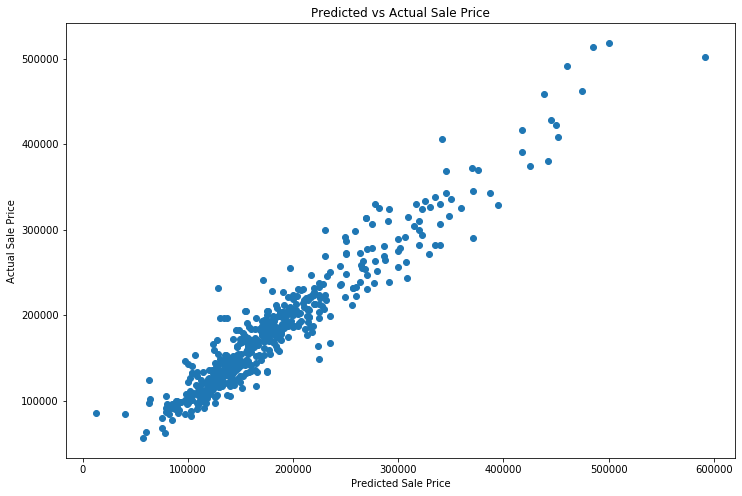

In [17]:
plt.figure(figsize = (12, 8))
plt.scatter(np.exp(y_test), y_test_preds)
plt.title('Predicted vs Actual Sale Price')
plt.xlabel('Predicted Sale Price')
plt.ylabel('Actual Sale Price');
plt.savefig('./imgs/OLS Predicted Vs Actual Sale Price')

Okay, we're getting a linear relationship between predicted and actuals here, so our model is making progress.

In [18]:
test_residuals = np.exp(y_test) - y_test_preds

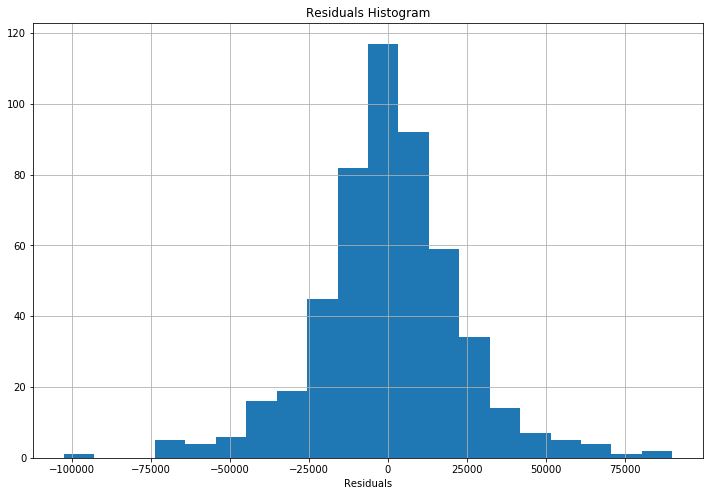

In [19]:
plt.figure(figsize = (12, 8))
test_residuals.hist(bins = 20)
plt.xlabel('Residuals')
plt.title('Residuals Histogram')
plt.savefig('./imgs/OLS Hist.png');

Our residuals are showing a more normal distribution at this point with a slight negative skew.  A significant improvement over previous iterations.

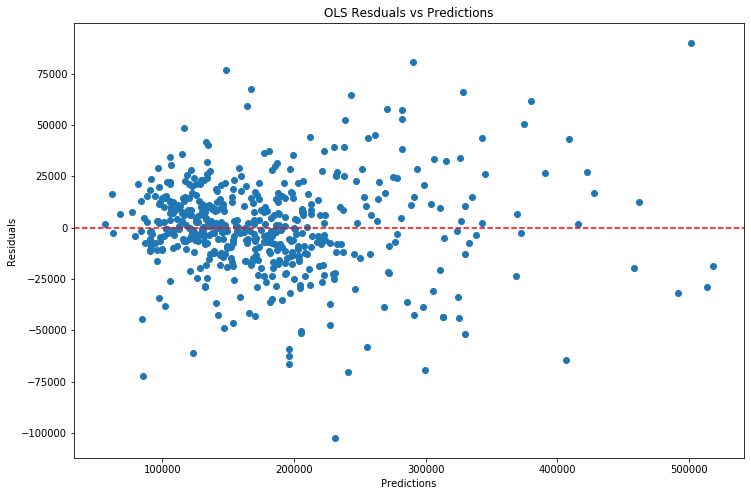

In [20]:
plt.figure(figsize = (12, 8))
plt.scatter(y_test_preds, test_residuals)
plt.xlabel('Predictions')
plt.ylabel('Residuals')
plt.axhline(c = 'red', ls = 'dashed')
plt.title('OLS Resduals vs Predictions')
plt.savefig('./imgs/Ols Resids Vs Preds.png');

We're showing a slight fanning with the residuals clustered at the smaller price range and becoming more spread out at higher values.  The model is better at predicting lower values.  This is the best option we've seen so far.

## __Conclusions and Visualizations__


There are several different strategies that can be pursued around maximizing sale price of a home and the stragegies will differ somewhat depending on the type of stakeholder. The Linear Regression model selected is able to account for 88% of the variability in the home's sale price and is able to predict the value within a 23k dollar range.

“If I am walking with two other men, each of them will serve as my teacher. I will pick out the good points of the one and imitate them, and the bad points of the other and correct them in myself."  - Confucius

I'm going to drill down into a few categories to better show the relationships between the offerings in the categories and the sale price.  In this case I'll first look at overall feature effect on sale price, then break it down by category.

What can buyers and sellers draw from this model?  Let's look at a few visualizations to find out.

In [21]:
columns = pd.Series(X.columns, name = "Feature")
coefs   = pd.Series(ols.coef_, name = "Coefficient")
coef_df = pd.concat([columns, coefs], axis = 1)
coef_df = coef_df.sort_values('Coefficient', ascending = False)

In [22]:
coef_df[coef_df['Feature'].str.contains('Neigh') == False]

,Feature,Coefficient
0,Overall Qual,0.083439
8,Fireplaces,0.053363
44,Mas Vnr Type_Stone,0.045643
43,Mas Vnr Type_None,0.030094
42,Mas Vnr Type_BrkFace,0.028318
2,Year Remod/Add,0.002492
1,Year Built,0.001960
5,Gr Liv Area,0.000286
9,Garage Area,0.000200
3,Total Bsmt SF,0.000139


In [23]:
beneficial_features = coef_df[(coef_df['Coefficient'] >= 0) & (coef_df['Feature'].str.contains('Neigh') == False)]
harmful_features = coef_df[(coef_df['Coefficient'] <= 0) & (coef_df['Feature'].str.contains('Neigh') == False)]

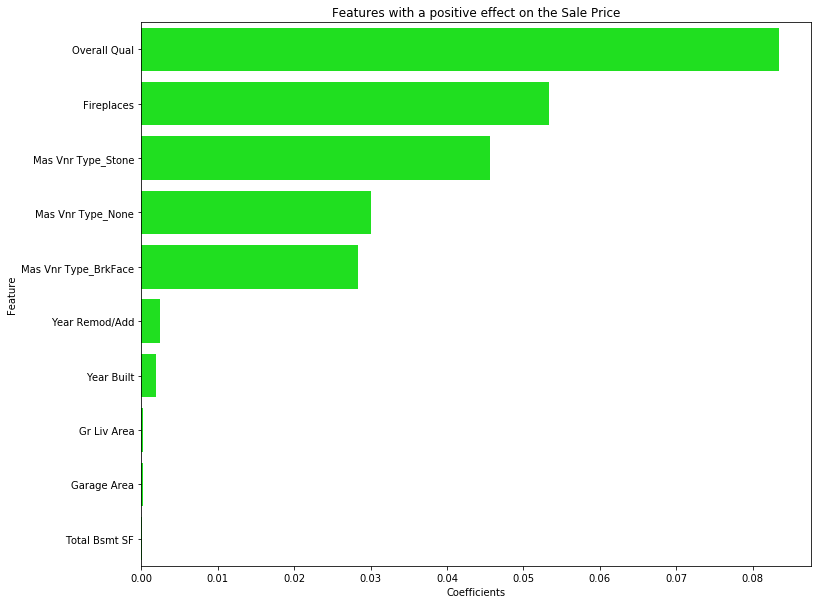

In [24]:
plt.figure(figsize = (12, 10))
plt.title('Features with a positive effect on the Sale Price')
sns.barplot(beneficial_features['Coefficient'], beneficial_features['Feature'], color = 'lime');
plt.xlabel('Coefficients')
plt.ylabel('Feature');
plt.savefig('./imgs/Positive Feature Effects.png')

For a homeowner looking to make changes to an existing home, the biggest impact to the home sale price would be generated by increasing the overall living area, where, all else being constant, each additional square foot added is expected to increase the home sale price by $138.  Barring the ability to add on to the home (due to zoning or space restrictions), the homeowner may want to consider if it is feasible to remove an masonry veneer attached to the home, as the impact of no masonry veneer is greater thean the impact of any other option.

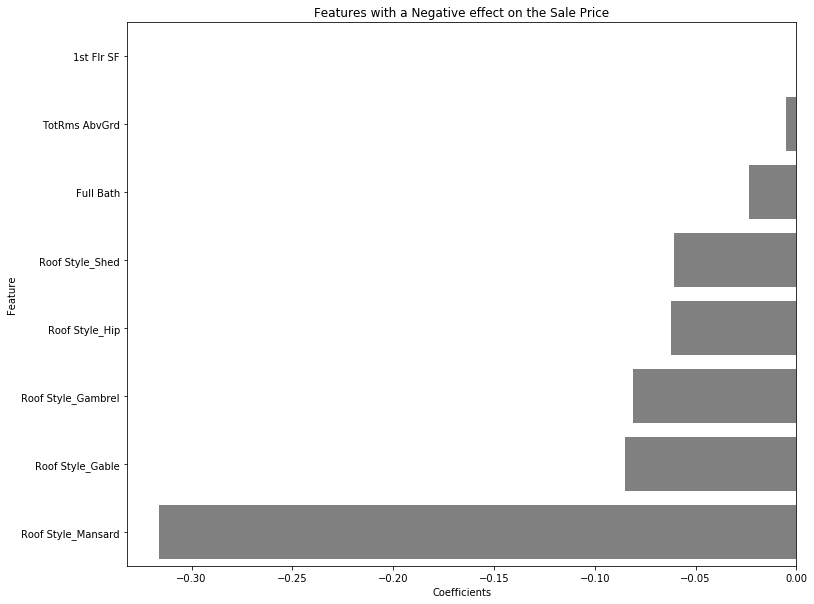

In [25]:
plt.figure(figsize = (12, 10))
plt.title('Features with a Negative effect on the Sale Price')
sns.barplot(harmful_features['Coefficient'], harmful_features['Feature'], color = 'grey');
plt.xlabel('Coefficients')
plt.ylabel('Feature');
plt.savefig('./imgs/Negative Feature Effects.png')

In [26]:
neighborhood_coefs = coef_df[(coef_df['Feature'].str.contains('Neigh'))]
pos_diff_ns = neighborhood_coefs[neighborhood_coefs['Coefficient'] >= 0]
neg_dif_ns = neighborhood_coefs[neighborhood_coefs['Coefficient'] <= 0]

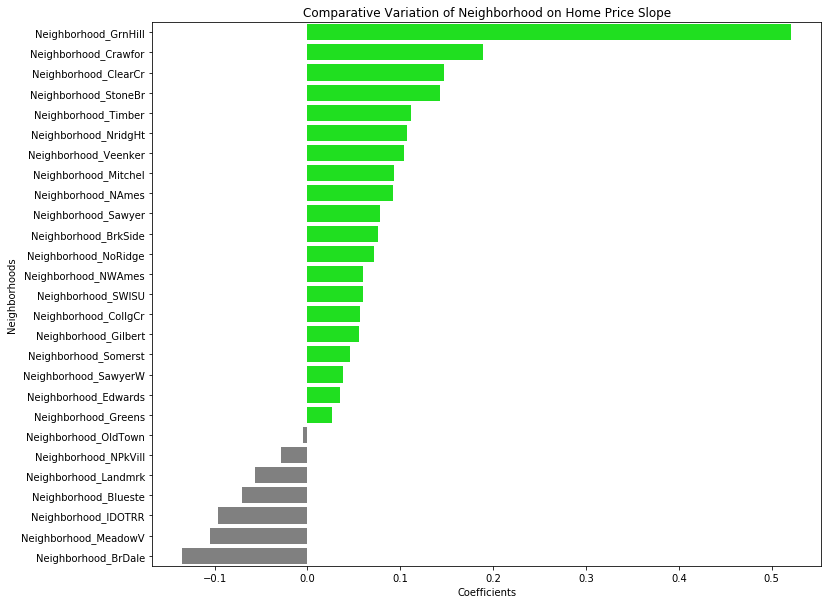

In [27]:
plt.figure(figsize = (12, 10))
plt.title('Comparative Variation of Neighborhood on Home Price Slope')
sns.barplot(pos_diff_ns['Coefficient'], neighborhood_coefs['Feature'], color = 'lime')
sns.barplot(neg_dif_ns['Coefficient'], neighborhood_coefs['Feature'], color = 'grey')
plt.xlabel('Coefficients')
plt.ylabel('Neighborhoods');
plt.savefig('./imgs/NeighborhoodCoefComp.png')

__Location, Location, Location__

We also see that neighborhoods have a strong impact on the sale price of a home.  

For an existing homeowner, this isn't as much in their control.  When looking to buy, a potential homeowner may want to consider how much of the home price is due to the location.

In [28]:
masonry_coefs = coef_df[(coef_df['Feature'].str.contains('Mas Vnr'))]
pos_diff_mas = masonry_coefs[masonry_coefs['Coefficient'] >= 0]
neg_dif_mas = masonry_coefs[masonry_coefs['Coefficient'] <= 0]

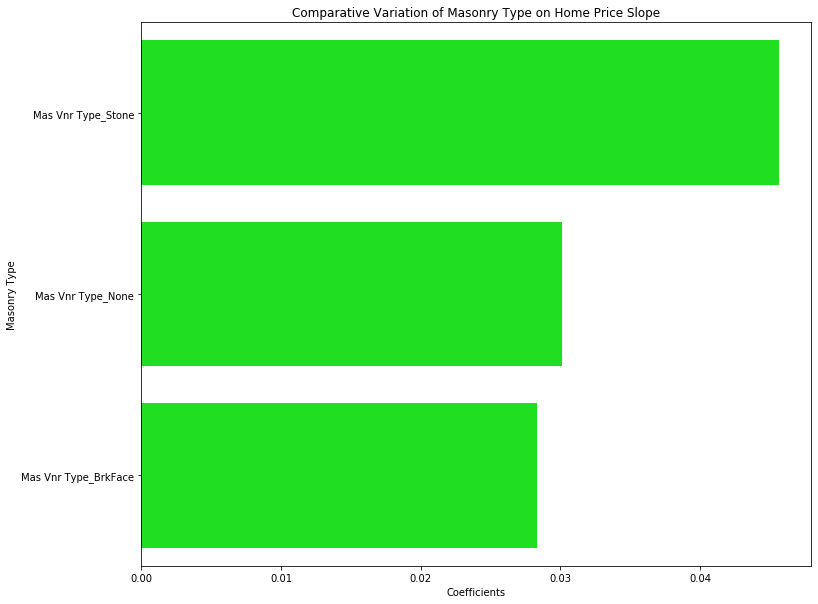

In [29]:
plt.figure(figsize = (12, 10))
plt.title('Comparative Variation of Masonry Type on Home Price Slope')
sns.barplot(pos_diff_mas['Coefficient'], pos_diff_mas['Feature'], color = 'lime')
plt.xlabel('Coefficients')
plt.ylabel('Masonry Type');
plt.savefig('./imgs/MasonryCoefComp.png')

In [30]:
roof_coefs = coef_df[(coef_df['Feature'].str.contains('Roof'))]
pos_diff_roof = roof_coefs[roof_coefs['Coefficient'] >= 0]
neg_dif_roof = roof_coefs[roof_coefs['Coefficient'] <= 0]

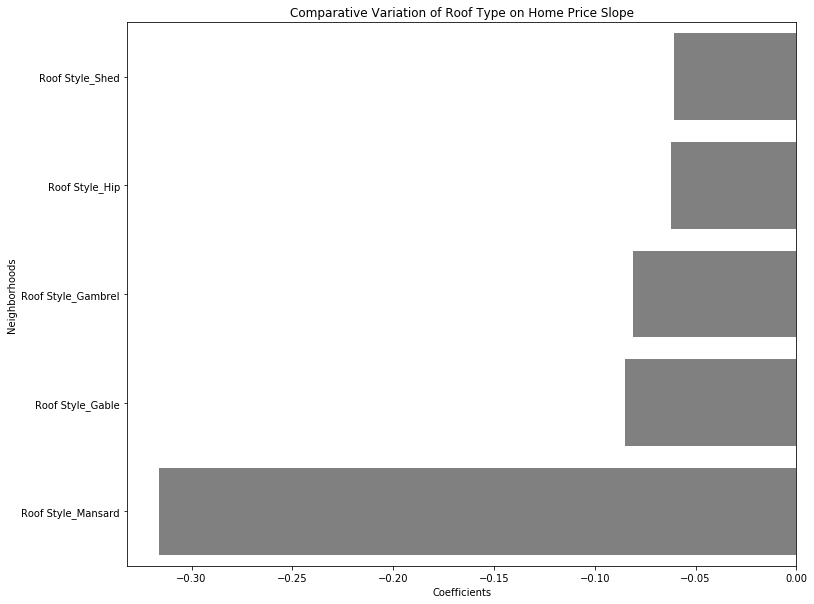

In [31]:
plt.figure(figsize = (12, 10))
plt.title('Comparative Variation of Roof Type on Home Price Slope')
sns.barplot(neg_dif_roof['Coefficient'], neg_dif_roof['Feature'], color = 'grey')
plt.xlabel('Coefficients')
plt.ylabel('Neighborhoods');
plt.savefig('./imgs/RoofCoefComp.png')

## Recommendations for Further Research